In [ ]:
"""
- BUILDS SEVERAL TRAJECTORIES BASED ON CAPTURED WAYPOINTS, SAVES THEM INTO A RADA FILE
- REPLAYS ALL THE TRAJECTORIES (WITH SHORT PAUSES TO REPOSITION THE CUBE), WHILE DENSELY RECORDING 
  JOINT ANGLES AND VIDEO FRAMES. RECORDS INTO 'RAD0.dat', 'RAD1.dat' FILES
      DICTIONARIES WITH KEYS ('joints', 'igm', 't')
- ALLOWS ONE TO SEE VIDEO AND JOINT ANGLES FROM RECORDED TRAJECTORIES
"""

In [1]:
from __future__ import print_function
import sys, os
import time
import pickle
import rospy
import numpy as np
from scipy import signal
import scipy
from sensor_msgs.msg import Image
from cv_bridge import CvBridge, CvBridgeError
import cv2

import matplotlib.pyplot as plt
import matplotlib.patches as patches

# wrapper/helper functions
sys.path.insert(0, '/home/torobo/catkin_ws/src/torobo_robot/torobo_rnn/scripts')
sys.path.insert(0, '/home/torobo/catkin_ws/src/tutorial/PyTorch-YOLOv3')
from torobo_rnn_utils__upd3 import *
from detect_upd import Recog, Recog2
from adjustExtForce_v3Controller import ExtForce

plt.switch_backend('nbAgg')

bridge = CvBridge()
torobo = ToroboOperator()
        
def echo(txt):
    sys.stdout.write('\r {}'.format(txt))
    sys.stdout.flush()
    
class NewRec(threading.Thread):

    """ RECORDS A DATASET FOR THE RNN """
    
    def __init__(self):
        threading.Thread.__init__(self)
        self.recording = False
        self.step = 0.1
        self.data = {}
    
    def run(self):
        if self.recording == True:
            self.recording = False
            print('Killing the previous recorder')
            time.sleep(1.5)
        self.recording = True
        self.record()
    
    def stop(self):
        self.recording = False
        time.sleep(1)
        print('Recording is {}'.format('ON' if self.is_alive() else 'OFF'))
        
        self.data['img'] = np.stack(self.data['img'])
        self.data['joints'] = np.stack(self.data['joints'])
        self.data['t'] = np.stack(self.data['t'])
        with open(self.fname, 'wb') as f:
            pickle.dump(self.data, f)
        print('Data saved')

        
    def record(self):
        global torobo, imagebuff
        print('Recording is {}'.format('ON' if self.is_alive() else 'OFF'))
        # overwrite
        if self.fname in os.listdir("."):
            open(self.fname, 'w').close()
        t = 0
        start_t = time.time()
        self.data['joints'] = []
        self.data['img'] = []
        self.data['t'] = []
        while self.recording:
            self.data['joints'].append(np.radians(get_cur_joints(torobo)[0]))
            self.data['img'].append(cv2.resize(imagebuff, (64,64), interpolation = cv2.INTER_AREA) )
            self.data['t'].append(time.time()-start_t)
            time.sleep(self.step)
            t += self.step

class Tracker(threading.Thread):
    """ - LOADS THE YOLO MODEL
        - FORWARD PASSES THE FRAME THROUGH THE MODEL
        - STORES BOUNDING BOX COORDINATES IN SELF.
    """
    
    def __init__(self):
        threading.Thread.__init__(self)
        
        checkpoint = 42
        self.recog = Recog2(checkpoint)
        
        self.x1, self.y1, self.x2, self.y2 = 0.0, 0.0, 0.0, 0.0
        self.new_hor = 0
        self.new_ver = 0
        self.Norm = scipy.stats.norm(0, 20)
        self.scale = self.Norm.pdf(0)
        
        self.keepgoing = False

    def stop(self):
        self.keepgoing = False

    def get_gaze_offset(self, cx, cy):
        return 640/2 - cx, 480/2 - cy
    
    def get_gaze_grad(self, offset_x, offset_y):
        ex = 0.2 * np.tanh(0.025*(offset_x))/ (1+self.Norm.pdf(offset_x)/self.scale*4)
        ey = 0.2 * np.tanh(0.025*(offset_y))/ (1+self.Norm.pdf(offset_x)/self.scale*4)
        return ex, ey

    def get_box_center(self, x1, y1, box_w, box_h):
        return x1 + box_w/2, y1 + box_h/2

    def track_obj(self, x,y,w,h):
        global torobo
        cx, cy = self.get_box_center(x, y, w, h)
        gaze_offset = self.get_gaze_offset(cx,cy)
        ex, ey = self.get_gaze_grad(*gaze_offset)
        hor, ver = get_cur_joints(torobo)[0][14:16]
        self.new_hor, self.new_ver = np.radians(hor)+ex, np.radians(ver)-ey

    def run(self):
        global imagebuff
        self.keepgoing = True
        while True and self.keepgoing:
            detections = self.recog.detect(imagebuff)
            if detections is not None:
                for det in detections:
                    for x1, y1, x2, y2, conf, cls_conf, cls_pred in detections:
                        if cls_pred == 0:
                            box_w = x2 - x1
                            box_h = y2 - y1
                            self.x1, self.y1, self.x2, self.y2 = x1, y1, x2, y2
                            x, y, w, h = x1, y1, box_w, box_h
                            self.track_obj(x, y, w, h)

In [2]:
with HiddenPrints():
    servo_on(torobo)

SUCCESS
SETTING MODE: set_external_force_following_online_trajectory_control
SETTING DYNAMIC PARAMETERS
OVERRIDES SET


In [3]:
""" TURN ON VIDEOSTREAMING FROM THE ROBOT'S CAMERA """

SRATE = 10
""" REPLAY @ 5 HZ, RECORD AT 10 HZ """
INTERVAL = 0.2
tracking = True


try:
    with HiddenPrints():
        if not 'imagebuff' in locals():
            imagebuff = 0
            def image_callback(msg):
                global imagebuff
                imagebuff = bridge.imgmsg_to_cv2(msg, "rgb8") 
            rospy.Subscriber("/camera/color/image_raw", Image, image_callback)

        set_velocity_override(torobo, 30.0)
        time.sleep(1)
    
    print('SUCCESS')
except:
    print('ERROR')

In [ ]:
# BUILDS SEVERAL TRAJECTORIES BASED ON CAPTURED WAYPOINTS, SAVES THEM INTO A RADA FILE

In [6]:
# Create a dictionary to hold the future data
RADA = {}

In [7]:
# Go to the START position
idx = 4
TIME = 3
torobo.set_control_mode(ToroboOperator.LEFT_ARM, 'all', 'position')
torobo.set_control_mode(ToroboOperator.RIGHT_ARM, 'all', 'position')
with open('rad.pickle', 'rb') as f:
    RAD = pickle.load(f)
    
left_arm_positions = RAD[idx][0:6]
right_arm_positions = RAD[idx][6:12]
torso_head_positions = RAD[idx][12:16]

torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
torobo.move(ToroboOperator.RIGHT_ARM, positions=left_arm_positions, duration=TIME)
torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
rospy.sleep(TIME+0.1)

[INFO] [1595741157.213540]: set_control_mode service client is called
[INFO] [1595741157.221349]: set_control_mode [['all']] is succeeded
[INFO] [1595741157.222658]: set_control_mode service client is called
[INFO] [1595741157.227448]: set_control_mode [['all']] is succeeded


In [70]:
# CREATE AN EMPTY NEW TRAJECTORY
traj_name = 'RAD2' # 'RAD0', 'RAD1', 'RAD2'
RADA[traj_name] = []
torobo.set_control_mode(ToroboOperator.LEFT_ARM, 'all', 'external_force_following')
torobo.set_control_mode(ToroboOperator.RIGHT_ARM, 'all', 'external_force_following')

[INFO] [1594602984.053188]: set_control_mode service client is called
[INFO] [1594602984.055639]: set_control_mode [['all']] is succeeded
[INFO] [1594602984.056050]: set_control_mode service client is called
[INFO] [1594602984.057633]: set_control_mode [['all']] is succeeded


In [78]:
# RECORD THE CURRENT WAYPOINT, AND APPEND IT TO THE CURRENT TRAJECTORY
cur_pos_deg, _ = get_cur_joints(torobo)
cur_pos_rad = np.radians(cur_pos_deg)
RADA[traj_name].append(cur_pos_rad)

In [79]:
# CHECK THE LENGHT OF THE CURRENT TRAJECTORY
len(RADA[traj_name])

5

In [82]:
# SAVE THE WAYPOINTS
with open('RADA.pickle', 'wb') as f:
    pickle.dump(RADA, f)

In [97]:
# REPLAY ALL THE TRAJECTORIES (WITH SHORT PAUSES TO REPOSITION THE CUBE),
# WHILE DENSELY RECORDING JOINT ANGLES AND VIDEO FRAMES

# DON'T FOGET TO GO TO THE STARTING POSITION FIRST !
SRATE = 10
TIME = 3
z

with HiddenPrints():
    torobo.set_control_mode(ToroboOperator.LEFT_ARM, 'all', 'position')
    torobo.set_control_mode(ToroboOperator.RIGHT_ARM, 'all', 'position')

for traj_name in RADA.keys():
    data_rec = NewRec()
    data_rec.fname = '{}.dat'.format(traj_name)
    data_rec.start()
    
    for a in [RADA[traj_name][1:], reversed(RADA[traj_name][:-1])]:

        for pos in a:
            left_arm_positions = pos[0:6]
            right_arm_positions = pos[6:12]
            torso_head_positions = pos[12:16]

            torobo.move(ToroboOperator.LEFT_ARM, positions=left_arm_positions, duration=TIME)
            torobo.move(ToroboOperator.RIGHT_ARM, positions=right_arm_positions, duration=TIME)
            torobo.move(ToroboOperator.TORSO_HEAD, positions=torso_head_positions, duration=TIME)
            rospy.sleep(TIME-0.4)
    data_rec.stop()
    time.sleep(4)

Recording is ON
Recording is OFF
Data saved
Recording is ON
Recording is OFF
Data saved
Recording is ON
Recording is OFF
Data saved


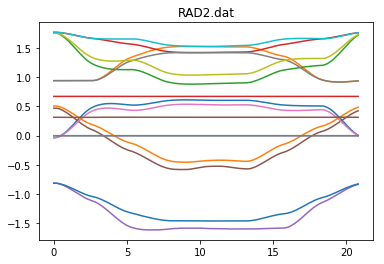

In [2]:
# SEE VIDEO FROM RECORDED TRAJECTORIES

traj_name = 'RAD2.dat'

%matplotlib inline
with open(traj_name, 'rb') as f:
    DAT = pickle.load(f)
    

cv2.namedWindow('I see')
cv2.setWindowProperty("I see", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)


i = 1

while True:
    try:
        time.sleep(0.1)
        img = DAT['img'][i,:,:,:].astype('uint8')
        img = np.copy(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        
        cv2.imshow('I see', img)
        k = cv2.waitKey(3) & 0XFF
        i += 1
        if k== 27 :
            cv2.destroyWindow('I see')
            break
    except:
        cv2.destroyWindow('I see')
        break

x = plt.plot(DAT['t'], DAT['joints'])
x = plt.title(traj_name)

In [ ]:
# SEE THE VIDEO FEED

import cv2
import numpy as np
import time
import pickle


cv2.namedWindow('I see')
cv2.setWindowProperty("I see", cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)


i = 1

while True:
    try:
        time.sleep(0.1)
        img = imagebuff.astype('uint8')
        img = np.copy(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        
        cv2.imshow('I see', img)
        k = cv2.waitKey(3) & 0XFF
        i += 1
        if k== 27 :
            cv2.destroyWindow('I see')
            break
    except:
        cv2.destroyWindow('I see')
        break